  ---

  
 # <span style="color:MediumSlateBlue     ">Final Project | Explainer Notebook.</span>

 ## <span style="color:MediumSlateBlue     ">Part 03 - Data Analysis 02 (Machine Learning).</span>


<span style="color:MediumSlateBlue     ">**02806 Social data analysis and visualization**</span>

<span style="color:MediumSlateBlue     ">**May 2021**</span>

<span style="color:MediumSlateBlue     "> **Data-sets Reference: Motor-Vihecle-Collisions<sup>[link](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95)</sup>, Weather-Data<sup>[link](https://www.ncdc.noaa.gov/cdo-web/search)</sup>, Speed-Limit-Data<sup>[link](https://data.cityofnewyork.us/Transportation/VZV_Speed-Limits/7n5j-865y)**</sup></span>

  ---
  

  
<span style="color:Orange">**Please note!**</span> If you are using Jupyter to display this ".ipynb" file You might need to make it *Trusted* in order to let Jupyter render the plots.
   

---

# <span style="color:MediumSlateBlue">Import Needed Libraries and set seed:</span>

---

First we start by importing needed Libraries

In [12]:
""" IPython """
from IPython.display import display
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

""" Data Handeling """
import numpy as np 
import pandas as pd 
from pandas import set_option
import calendar
import os 

""" Plot """ 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

""" for warnings """
import warnings 
warnings.simplefilter("ignore")

""" for Statistic """
from scipy.stats import ks_2samp

""" for Data Preprocessing  """
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

""" for Cross Validation """
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

""" for Models """
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

""" for Report Metrics """ 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix

""" seed """
seed = 123


---

# <span style="color:MediumSlateBlue">Load Data:</span>

---


In [13]:
""" Path """
fileName = 'MVC_SL_W_Final.csv'
filePath = os.path.abspath(os.path.join(os.getcwd(), fileName))

""" Load """
Data =  pd.read_csv(filePath, index_col=0);



---

# <span style="color:MediumSlateBlue">Testing for different spatio-temporal distribution:</span>

---


 [**Kolmogorov-Smirnov statistic**](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) of the two response values is tested, accordingly **on the attributes 'LATITUDE', 'Hour' and 'Month'**. 
 
Specifically, the two-sample Kolmogorov-Smirnov test is performed to check whether the response labels are drawn from the same distribution under the significance level $α = 0.05$. If the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples is the same. 

In [14]:
""" Kolmogorov-Smirnov on Latitude """
d1 = Data[Data['Response'] == 0]['LATITUDE']
d2 = Data[Data['Response'] == 1]['LATITUDE']
print("Test for Latitude different distribution under \u03B1 = 0.5 is: ", ks_2samp(d1, d2)[1]<0.5)

Test for Latitude different distribution under α = 0.5 is:  True


In [15]:

""" Kolmogorov-Smirnov on Hour """
d1 = Data[Data['Response'] == 0]['Hour']
d2 = Data[Data['Response'] == 1]['Hour']
print("Test for Hour different distribution under \u03B1 = 0.5 is: ", ks_2samp(d1, d2)[1]<0.5)

Test for Hour different distribution under α = 0.5 is:  True


In [16]:
""" Kolmogorov-Smirnov on Month  """
d1 = Data[Data['Response'] == 0]['Month']
d2 = Data[Data['Response'] == 1]['Month']
print("Test for Month different distribution under \u03B1 = 0.5 is: ", ks_2samp(d1, d2)[1]<0.5)

Test for Month different distribution under α = 0.5 is:  True


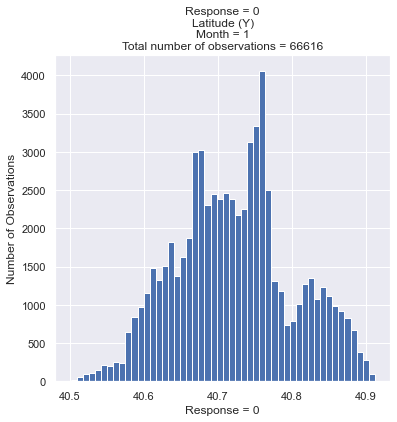

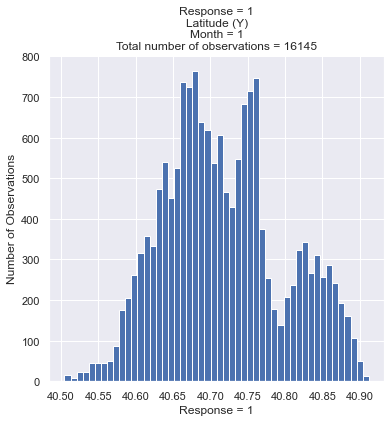

In [17]:
""" Plot the two response distribution for January """
month = 1
for response in [0,1]:
    d = Data[Data['Response'] == response]
    d = d[d['Month']==month]
    plt.figure(figsize=(6, 6))
    plt.hist(d['LATITUDE'], bins=50) 
    plt.title( "Response = " + str(response) + "\nLatitude (Y)" + '\nMonth = '+ str(month) + '\nTotal number of observations = '+ str(len(d)))
    plt.xlabel("Response = " + str(response))
    plt.ylabel('Number of Observations')
    plt.show()

""" free memory """
del (d,d1,d2)

Above are histograms that show the latitude distribution of the two 'Response' labels, in only January from 2013 until 2021 using 50 bins. It can be seen that the two crimes histograms shows different spatio-temporal distributions.


---

# <span style="color:MediumSlateBlue">Slice needed features for learning:</span>

---
Below we slice the needed features for learning:

    Y: 'Response'
    
    X-Matrix: 
        Time features: 'Month', 'Day of week', 'Hour' 
        Place features: 'ON STREET NAME'
        Vehicle features: 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2'
        Casual features: 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2'
        Speed Features: 'SPEED LIMIT MODE'
        Weather features: 'PRECIPITATION', 'SNOW FALL', 'SNOW DEPTH','FOG, SMOKE OR HAZE', 'AVERAGE WIND SPEED', 'MAXIMUM TEMPERATURE', 'MINIMUM TEMPERATURE'.

We dropped the 'LATITUDE', 'LONGITUDE',  'BOROUGH' and 'ZIP CODE' since we have 'ON STREET NAME'. On the other hand, combining the three features Month, DayOfWeek and Hour can best describe the time-related information.

In [18]:
""" Slice features for learning: """ 
data = Data[['Response', 'Month', 'Day of week', 'Hour', 'ON STREET NAME','VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2','CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2','SPEED LIMIT MODE','PRECIPITATION', 'SNOW FALL', 'SNOW DEPTH','FOG, SMOKE OR HAZE', 'AVERAGE WIND SPEED', 'MAXIMUM TEMPERATURE', 'MINIMUM TEMPERATURE']].copy()

""" free memory """
del(Data)

---

# <span style="color:MediumSlateBlue">Class Balance:</span>

---

Since we don't want to increase the probability of classifying any new random point as the class (Response = 0) with more occurrences.

Here we will use the **Down-sample Majority Class** method
see [link](https://elitedatascience.com/imbalanced-classes)


In [19]:
""" count data """
print('Count Response labels before Class Balance:')
print(data['Response'].value_counts())

""" Separate majority and minority classes """
data_majority   = data[data['Response']==0]
data_minority   = data[data['Response']==1]
 
""" Downsample class """
data_majority = resample(data_majority, 
                    replace=False,                  # sample without replacement
                    n_samples=len(data_minority),   # to match minority class
                    random_state=seed)              # reproducible results

data_minority = resample(data_minority, 
                    replace=False,                  # sample without replacement
                    n_samples=len(data_minority),   # to match minority class
                    random_state=seed)              # reproducible results


""" Combine minority class with downsampled majority class """
data_downsampled = pd.concat([data_majority, data_minority])

""" Shuffle DataFrame rows and reset index """
data = data_downsampled.sample(frac=1, random_state=seed).reset_index(drop=True)

""" Check and Display new class counts """
print('\nCount Response labels after Class Balance:')
print(data['Response'].value_counts())

""" free memory """
del(data_majority,data_minority,data_downsampled)

Count Response labels before Class Balance:
0    758237
1    200134
Name: Response, dtype: int64

Count Response labels after Class Balance:
1    200134
0    200134
Name: Response, dtype: int64


---

# <span style="color:MediumSlateBlue">Define Data Preprocessor:</span>

---

The below preprocessor will be used as a first step in the pipeline models for **data processing**. Defining it this way can allow us to use it in each cross-validate fold. The reason behind that is to prevent leaking information from training to test data.

In [20]:
""" numerical features """
numeric_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('stand', StandardScaler())
        ])

""" categorical features """
categorical_transformer = Pipeline(
    steps = [
        ('enc', OrdinalEncoder(handle_unknown= 'ignore')),
        ('stand', StandardScaler())
        ])

""" Features-preprocessor """
num_cols = list(data.select_dtypes('number').columns)
num_cols.remove('Response')
cat_cols = list(data.select_dtypes('object').columns)
preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer,num_cols),
        ('cat', categorical_transformer,cat_cols )
        ])

---

# <span style="color:MediumSlateBlue">Split data for Learning:</span>

---


In [21]:
""" Split-out X,Y dataset """
X = data.iloc[:,1:]
Y = data.iloc[:,0]

""" Split-out validation dataset """
validation_size = 0.95  
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,test_size=validation_size, random_state=seed, stratify=Y)
print (f'{len(Y_train)} samples to train on and {len(Y_validation)} to validate the final model on (unseen data)')

20013 samples to train on and 380255 to validate the final model on (unseen data)


---

# <span style="color:MediumSlateBlue">Compare Algorithms:</span>

---

Here we compare the performance of the two algorithms we have been introduced to **RandomForest vs DecisionTree** on the training data (Both with sklearn default settings) using 5 Stratified fold CV.


Here we chose to have recall (also called the Sensitivity) as a scoring metric since it is the true positive rate. It is the number of instances from the positive (response = 1) class that actually predicted correctly and this is what we are intressted in.

RF: 0.578594 (0.004046)
DT: 0.609672 (0.007001)


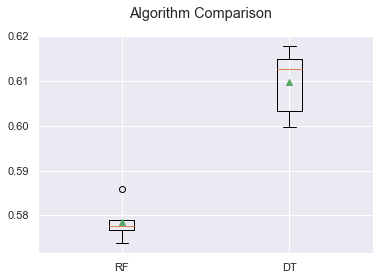

In [22]:
""" scoring """
scoring = 'recall'

""" Pipelines """
pipelines = []
pipelines.append(('RF', Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier())])))
pipelines.append(('DT', Pipeline([('preprocessor', preprocessor),('dt',DecisionTreeClassifier())])))

""" CV """
results = []
names = []
for name, model in pipelines:
    skfold = StratifiedKFold(n_splits=5,shuffle= True, random_state=seed) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=skfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

""" Compare Algorithms """
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, showmeans=True)
ax.set_xticklabels(names)
plt.show()

Above are the Box and Whisker plots comparing the two algorithms, **RandomForest vs Logistic Regression**, Performance. It's seen that RandomForest outcome Logistic Regression on sklearn default settings. Therefore it's worth it to start tuning RandomForestClassifier and investigate it more.

---

# <span style="color:MediumSlateBlue">Tunning:</span>

---

 ** RandomForestClassifier tuning:**
 By the mean of Randomized Grid Search CV we are goin to investigate: 
 - Explore Number of Trees    (n_estimators)      = to be investegated with CV.
 - Explore Minimum Node Size  (min_samples_leaf)  = to be investegated with CV.
 - Explore Number of Features (max_features)      = 'sqrt' (Heuristic: the square root of the number of input features).

In [17]:
""" Define models """
model = Pipeline([
    ('preprocessor', preprocessor),
    ('rf',RandomForestClassifier(max_features = 'sqrt'))
    ])

""" Define grid parameters """
n_estimators = [100,500,1000]
min_samples_leaf = [1, 50, 100]
grid = dict(rf__n_estimators=n_estimators, rf__min_samples_leaf=min_samples_leaf)

""" Define grid search """
cv = StratifiedKFold(n_splits=5,shuffle= True, random_state=seed)
random_grid_search = RandomizedSearchCV(estimator = model, param_distributions = grid, scoring=scoring, n_iter = 6, cv = cv, verbose=2, n_jobs = 4)
grid_result = random_grid_search.fit(X_train, Y_train)

""" best results """
print("Best Recall: %f (%f) \nUsing %s" % (grid_result.best_score_, grid_result.cv_results_['std_test_score'][grid_result.best_index_], grid_result.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Accuracy: 0.569502 (0.004133) 
Using {'rf__n_estimators': 500, 'rf__min_samples_leaf': 1}


---

# <span style="color:MediumSlateBlue">Report:</span>

---

Here we save the Final Model with the **best hyperparameters** founded in last Random Grid Search.

Finally, it's time to test the Final Model on the validation (unseen) data and Report results. **See Discussion for results analysis**  

In [18]:
""" Prepare Final Model """
model = Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier( max_features = 'sqrt', n_estimators= 500, min_samples_leaf = 1))]);
model.fit(X_train, Y_train);

In [19]:
""" Classification Report """
predictions = model.predict(X_validation)
print('Accuracy= %.3f' % accuracy_score(Y_validation, predictions))
print('\nClassification Report:\n',classification_report(Y_validation, predictions))

Accuracy= 0.679

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.78      0.71    190128
           1       0.72      0.58      0.64    190127

    accuracy                           0.68    380255
   macro avg       0.69      0.68      0.68    380255
weighted avg       0.69      0.68      0.68    380255



<Figure size 432x288 with 0 Axes>

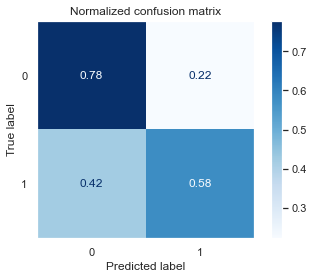

In [20]:
""" Confusion Matrix """
plt.figure()
disp = plot_confusion_matrix(model, X_validation, Y_validation, cmap=plt.cm.Blues, normalize='true', include_values= True) 
disp.ax_.set_title('Normalized confusion matrix')
plt.grid(False)
plt.show()

---

# <span style="color:MediumSlateBlue">Feature importance:</span>

---

Here you go a 2 fold CV to check feature importance. This can be useful not only to check feature importance but also to improve the model or to come with a simpler model that has a relatively reasonable performance.

In [23]:
result = permutation_importance(model, X_train, Y_train, n_repeats=2,random_state=seed, scoring='accuracy')
col_names = list(X_train.columns)

for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
         print(f"{col_names[i]:<40}"
               f"{result.importances_mean[i]:.3f}"
               f" +/- {result.importances_std[i]:.3f}")

VEHICLE TYPE CODE 2                     0.235 +/- 0.001
CONTRIBUTING FACTOR VEHICLE 2           0.204 +/- 0.000
CONTRIBUTING FACTOR VEHICLE 1           0.104 +/- 0.001
ON STREET NAME                          0.089 +/- 0.001
Hour                                    0.081 +/- 0.001
VEHICLE TYPE CODE 1                     0.041 +/- 0.000
AVERAGE WIND SPEED                      0.034 +/- 0.001
MINIMUM TEMPERATURE                     0.019 +/- 0.000
Month                                   0.017 +/- 0.000
MAXIMUM TEMPERATURE                     0.016 +/- 0.000
SPEED LIMIT MODE                        0.012 +/- 0.000
Day of week                             0.012 +/- 0.001
PRECIPITATION                           0.012 +/- 0.000
SNOW DEPTH                              0.005 +/- 0.000
FOG, SMOKE OR HAZE                      0.001 +/- 0.000
SNOW FALL                               0.000 +/- 0.000


---
# Discussion: 
---

>**Explain about your choices for training/test data, features, and encoding. (You decide how to present your results, but here are some example topics to consider: Did you balance the training data? What are the pros/cons of balancing? Do you think your model is overfitting? Did you choose to do cross-validation? Which specific features did you end up using? Why? Which features (if any) did you one-hot encode? Why ... or why not?))**

***Below is a summary of the algorithm we used to approach solving the classification problem at hand:***
- Load Crime Dataset. 
- Check that the selected two Response labels have indeed different Spatio-temporal distribution (Kolmogorov-Smirnov statistic and histogram)
- Balance Dataset.
- Defined a Data Preprocessor (To be used in each cross-validate fold to prevent leaking information from training to test data).  
- Split Data in stratified way randomly, 5% training 95% validation. (5% to train on is still a lot of data).
- Compare both models with naive (SKlearn deafult) parameters (5 Stratified KFold CV: Random-forest vs LogisticRegression).
- Start tuning the best performing algorithm: 
    - Random Grid Search (5 Stratified KFold CV) to find hyperparameters focus area.
- Define the final model according to the best combination of hyperparameters founded using the Random Grid search. 
- Validate the final model on the validation (unseen) data set and Report.
- Investigate which features are the most important.


***Below is a clarification of the choices we made:*** 
- Choice of features:
  - We choose the features that best describe the Spatio-temporal, Vehicle, causal and weather patterns of a MVC.
- Choice of label encoding: 
  - The number of categories is a bit large within the categorical variables and one-hot encoding can lead to high memory consumption.
  - label encoding can lead to an ordinality problem which means that not-ordinal variables will have an order. Howeever,
  decisions trees work based on increasing the homogeneity of the next level. Thus, it might not be a big problem to label encode the categorical variable here.   
- Choice of class balance: 
  - Since we don't want to increase the probability of classifying any new random point as the class with more examples.
  - The coins is that our model will be trained in a way that emphasizes the minority classes more in favour of the majority class which might not represent the real population.  
- Choices of training/test data:  
  - Split Data in stratified way randomly, 5% training 95% validation since:  
    - We indeed have a lot of data! 5% correspond to 20013  samples to train and 95% correspond to 380255 samples (unseen data) to validate the final model. 
    - Having relatively more data to validate the final can give a more generalized sense of how the model would act on future data. 
    - Having a relatively less but reasonable amount of data(> 10,000) to train on would reduce the computational power needed to tune the model.
    - Random splits since we want to generalize.
    - Stratified splits since we want each split to be balanced. 
  - Tuning the model with 5 Stratified KFold CV since:    
    - We want to minimize the testing bias by having a sufficiently large portion of the dataset for training. Thus, we choose 4/5 of the training data to train on.
    - We want to minimize the testing variance by having a sufficiently large portion of the dataset for testing. Thus, we choose 1/5 of the training data to test on.
- Overfitting:
  - Our model generalizes very well to the validation data (new unseen data) which means that our model is not overfitting.
